# 딥러닝 중간고사 대체과제

## MLP를 통한 Multi-class classification
1. Feed-forward, Back-propagation 구현
2. MLP의 hidden layer 노드 숫자 제한 x
3. scikit-learn의 MLP와 성능 비교
4. 구현한 MLP의 성능이 scikit-learn보다 낮다면, 성능 향상 위한 여러 방법 시도
5. 구현한 MLP의 성능이 scikit-learn보다 높다면, 성능 향상 위한 여러 방법 시도

**필수** : iris data를 활용하여 MLP from scratch 구현  
**옵션** : MNIST data를 활용하여 Fully connected MLP from scratch 구현

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, f1_score

In [2]:
class MLP:
    def __init__(self, hidden_size, learning_rate, epochs):
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        # 입력층과 은닉층 사이의 가중치, 은닉층 편향
        self.weights_1 = None
        self.bias_1 = None
        # 은닉층과 출력층 사이의 가중치, 출력층 편향
        self.weights_2 = None
        self.bias_2 = None
        # loss 값 저장
        self.loss_list = []
        
    # 활성화함수, 시그모이드 -> 0~1 사이의 확률값
    def sigmoid(self, X):
        X = np.clip(X, -300, 300)
        return 1 / (1 + np.exp(-X))

    # 시그모이드의 미분
    def sigmoid_derivative(self, X):
        X = np.clip(X, -300, 300)
        return (np.exp(-X)) / ((np.exp(-X) + 1) ** 2)

    # 출력함수, 소프트맥스 -> 총합이 1인 0~1 사이의 확률값
    def softmax(self, X):
        e_x = np.exp(X - np.max(X, axis = 1).reshape(X.shape[0],1))
        return e_x / np.sum(e_x, axis=1).reshape(X.shape[0],1)
        
    # 손실함수, Cross Entropy
    def cross_entropy(self, y_true, y_pred):
        y_pred = np.clip(y_pred, 0.0001, 0.9999)
        return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
    
    def feedforward(self, X):
        # (데이터의 개수,데이터 속성의 개수) * (데이터 속성의 개수,Hidden) + (1,Hidden) = (데이터의 개수,Hidden)
        self.hidden_layer_input = np.dot(X, self.weights_1) + self.bias_1
        self.hidden_layer_output = self.sigmoid(self.hidden_layer_input)

        # (데이터의 개수,Hidden) * (Hidden,Output) + (1,Output) = (데이터의 개수,Output)
        self.output_layer_input = np.dot(self.hidden_layer_output, self.weights_2) + self.bias_2
        self.output_layer_output = self.softmax(self.output_layer_input)
        
    def backpropagation(self, X, y):
        # cross_entropy 오차의 역전파를 통한 가중치와 편향을 조정
        # 전체 loss
        loss = self.cross_entropy(y, self.output_layer_output)
        self.loss_list.append(loss)
        
        # 출력층 오차, 전체 loss에 대한 출력층 입력값(self.output_layer_input)의 편미분 값 : Equation 1을 통한 증명
        error_output = (self.output_layer_output - y)
        # 전체 데이터에 대한 누적값이기 때문에 평균 연산 수행
        deltha_weight_2 = np.dot(self.hidden_layer_output.T, error_output) / X.shape[0]
        deltha_bias_2 = np.mean(error_output, axis=0)

        # 은닉층 오차, 전체 loss에 대한 은닉층 입력값(self.hidden_layer_input)의 편미분 값 : Equation 1을 통한 증명
        error_hidden = np.dot(error_output, self.weights_2.T) * self.sigmoid_derivative(self.hidden_layer_input)
        # 전체 데이터에 대한 누적값이기 때문에 평균 연산 수행
        deltha_weight_1 = np.dot(X.T, error_hidden) / X.shape[0]
        deltha_bias_1 = np.mean(error_hidden, axis=0)
        
        # 가중치 조정
        self.weights_2 -= deltha_weight_2 * self.learning_rate
        self.bias_2 -= deltha_bias_2 * self.learning_rate
        self.weights_1 -= deltha_weight_1 * self.learning_rate
        self.bias_1 -= deltha_bias_1 * self.learning_rate
        
    def train(self, X, y):
        for epoch in range(self.epochs):
            self.feedforward(X)
            self.backpropagation(X,y)
            if epoch % 10 == 0:
                loss = self.cross_entropy(y, self.output_layer_output)
                print(f"epoch {epoch}, loss {loss}")  
                
    def retrunLossList(self):
        return self.loss_list
    
    def predict(self, X):
        self.feedforward(X)
        return np.argmax(self.output_layer_output, axis=1)
                
    def fit(self, X, y):
        # 데이터의 속성 개수
        input_size = X.shape[1]
        # 데이터의 분류 개수, 라벨의 개수
        output_size = len(np.unique(y))
        
        # 입력층 -> 은닉층 가중치 : (데이터 속성의 개수,Hidden) and 은닉층 편향 : (1,hidden)
        self.weights_1 = np.random.randn(input_size, self.hidden_size)
        self.bias_1 = np.ones((1, self.hidden_size))
        
        # 은닉층 -> 출력층 가중치 : (Hidden,Output) and 출력층 편향 : (1,Output)
        self.weights_2 = np.random.randn(self.hidden_size, output_size)
        self.bias_2 = np.ones((1, output_size))

        # numpy 배열로의 변환 및 target 값 원핫인코딩
        X = np.array(X)
        y = np.array(pd.get_dummies(y['target']))
        
        # 입력된 데이터로 학습 진행
        self.train(X, y)

In [3]:
class MLP_MINIBATCH:
    def __init__(self, hidden_size, learning_rate, epochs, batch_size):
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        # 입력층과 은닉층 사이의 가중치, 은닉층 편향
        self.weights_1 = None
        self.bias_1 = None
        # 은닉층과 출력층 사이의 가중치, 출력층 편향
        self.weights_2 = None
        self.bias_2 = None
        # loss 값 저장
        self.loss_list = []
        
    # 활성화함수, 시그모이드 -> 0~1 사이의 확률값
    def sigmoid(self, X):
        X = np.clip(X, -300, 300)
        return 1 / (1 + np.exp(-X))

    # 시그모이드의 미분
    def sigmoid_derivative(self, X):
        X = np.clip(X, -300, 300)
        return (np.exp(-X)) / ((np.exp(-X) + 1) ** 2)

    # 출력함수, 소프트맥스 -> 총합이 1인 0~1 사이의 확률값
    def softmax(self, X):
        e_x = np.exp(X - np.max(X, axis = 1).reshape(X.shape[0],1))
        return e_x / np.sum(e_x, axis=1).reshape(X.shape[0],1)
        
    # 손실함수, Cross Entropy
    def cross_entropy(self, y_true, y_pred):
        y_pred = np.clip(y_pred, 0.0001, 0.9999)
        return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
    
    def feedforward(self, X):
        # (데이터의 개수,데이터 속성의 개수) * (데이터 속성의 개수,Hidden) + (1,Hidden) = (데이터의 개수,Hidden)
        self.hidden_layer_input = np.dot(X, self.weights_1) + self.bias_1
        self.hidden_layer_output = self.sigmoid(self.hidden_layer_input)

        # (데이터의 개수,Hidden) * (Hidden,Output) + (1,Output) = (데이터의 개수,Output)
        self.output_layer_input = np.dot(self.hidden_layer_output, self.weights_2) + self.bias_2
        self.output_layer_output = self.softmax(self.output_layer_input)
        
    def backpropagation(self, X, y):
        # cross_entropy 오차의 역전파를 통한 가중치와 편향을 조정
        # 전체 loss
        loss = self.cross_entropy(y, self.output_layer_output)
        self.loss_list.append(loss)
        
        # 출력층 오차, 전체 loss에 대한 출력층 입력값(self.output_layer_input)의 편미분 값 : Equation 1을 통한 증명
        error_output = (self.output_layer_output - y)
        # 전체 데이터에 대한 누적값이기 때문에 평균 연산 수행
        deltha_weight_2 = np.dot(self.hidden_layer_output.T, error_output) / X.shape[0]
        deltha_bias_2 = np.mean(error_output, axis=0)

        # 은닉층 오차, 전체 loss에 대한 은닉층 입력값(self.hidden_layer_input)의 편미분 값 : Equation 1을 통한 증명
        error_hidden = np.dot(error_output, self.weights_2.T) * self.sigmoid_derivative(self.hidden_layer_input)
        # 전체 데이터에 대한 누적값이기 때문에 평균 연산 수행
        deltha_weight_1 = np.dot(X.T, error_hidden) / X.shape[0]
        deltha_bias_1 = np.mean(error_hidden, axis=0)
        
        # 가중치 조정
        self.weights_2 -= deltha_weight_2 * self.learning_rate
        self.bias_2 -= deltha_bias_2 * self.learning_rate
        self.weights_1 -= deltha_weight_1 * self.learning_rate
        self.bias_1 -= deltha_bias_1 * self.learning_rate
        
    def train(self, X, y):
        num_samples = X.shape[0]
        for epoch in range(self.epochs):
            for i in range(0, num_samples, self.batch_size):
                X_batch = X[i:i+self.batch_size]
                y_batch = y[i:i+self.batch_size]
                
                self.feedforward(X_batch)
                self.backpropagation(X_batch, y_batch)

            if epoch % 10 == 0:
                loss = self.cross_entropy(y_batch, self.output_layer_output)
                print(f"epoch {epoch}, loss {loss}")  
 
    def retrunLossList(self):
        return self.loss_list
        
    def predict(self, X):
        self.feedforward(X)
        return np.argmax(self.output_layer_output, axis=1)
                
    def fit(self, X, y):
        # 데이터의 속성 개수
        input_size = X.shape[1]
        # 데이터의 분류 개수, 라벨의 개수
        output_size = len(np.unique(y))
        
        # 입력층 -> 은닉층 가중치 : (데이터 속성의 개수,Hidden) and 은닉층 편향 : (1,hidden)
        self.weights_1 = np.random.randn(input_size, self.hidden_size)
        self.bias_1 = np.ones((1, self.hidden_size))
        
        # 은닉층 -> 출력층 가중치 : (Hidden,Output) and 출력층 편향 : (1,Output)
        self.weights_2 = np.random.randn(self.hidden_size, output_size)
        self.bias_2 = np.ones((1, output_size))

        # numpy 배열로의 변환 및 target 값 원핫인코딩
        X = np.array(X)
        y = np.array(pd.get_dummies(y['target']))
        
        # 입력된 데이터로 학습 진행
        self.train(X, y)

In [4]:
def printMultilabelConfusionMatrix(y_val, y_pred):
    cm = multilabel_confusion_matrix(y_val, y_pred)
    for i in range(len(cm)):
        print(f"라벨 {i}의 혼동행렬 :")
        temp = pd.DataFrame(cm[i])
        temp.index = ['실제값 N','실제값 T']
        temp.columns = ['예측값 N','예측값 T']
        print(temp)
        print('='*20)

### iris data

In [5]:
from sklearn.datasets import load_iris

In [6]:
iris = load_iris()

In [7]:
print(iris)

{'data': array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
     

In [8]:
def targetToNames(x):
    return iris['target_names'][x]

iris_df = pd.DataFrame(data=iris['data'], columns=iris['feature_names'])
iris_df['target'] = iris['target']
iris_df['target_name'] = iris_df['target'].apply(lambda x : targetToNames(x))

In [9]:
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [10]:
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
 5   target_name        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


In [11]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

X = iris_df.iloc[:,0:4].copy()
y = iris_df.iloc[:, 4:5].copy()

accuracy_list = []
f1_list = []
val_list = []
pred_list = []

# k-fold 교차 검증 수행
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # 모델 학습 및 평가
    model = MLP(hidden_size=10, learning_rate=0.08, epochs=1800)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy_list.append(accuracy_score(y_val, y_pred))
    f1_list.append(f1_score(y_val, y_pred, average='weighted'))
    val_list.append(y_val)
    pred_list.append(y_pred)
    
print(f"accuracy: {accuracy_list}")
print(f"F1 weighted: {f1_list}")

for i in range(len(val_list)):
    print(f"Fold : {i}")
    printMultilabelConfusionMatrix(val_list[i], pred_list[i])
    print('='*20)

epoch 0, loss 2.490586152641238
epoch 10, loss 0.9928204743661712
epoch 20, loss 0.8074404281304938
epoch 30, loss 0.7529760330561399
epoch 40, loss 0.7020158975252246
epoch 50, loss 0.65351071272467
epoch 60, loss 0.6189038533513782
epoch 70, loss 0.5957254093592721
epoch 80, loss 0.5780196528651745
epoch 90, loss 0.5633848816107668
epoch 100, loss 0.550772458968244
epoch 110, loss 0.5396035027311578
epoch 120, loss 0.529501621139581
epoch 130, loss 0.5201929830364062
epoch 140, loss 0.5114597205404654
epoch 150, loss 0.5031102962386431
epoch 160, loss 0.4949522022759909
epoch 170, loss 0.48675767988168595
epoch 180, loss 0.47821744740656463
epoch 190, loss 0.4689116024190048
epoch 200, loss 0.4584719594889792
epoch 210, loss 0.447169850398571
epoch 220, loss 0.4359832488358299
epoch 230, loss 0.4252708261624459
epoch 240, loss 0.4144771726255068
epoch 250, loss 0.4024950207750944
epoch 260, loss 0.38649385372540224
epoch 270, loss 0.3560953855284138
epoch 280, loss 0.3095999737849254

In [12]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

X = iris_df.iloc[:,0:4].copy()
y = iris_df.iloc[:, 4:5].copy()

accuracy_list = []
f1_list = []
val_list = []
pred_list = []

# k-fold 교차 검증 수행
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # 표준화
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    
    # 모델 학습 및 평가
    model = MLP(hidden_size=10, learning_rate=0.08, epochs=1800)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy_list.append(accuracy_score(y_val,y_pred))
    f1_list.append(f1_score(y_val, y_pred, average='weighted'))
    val_list.append(y_val)
    pred_list.append(y_pred)
    
print(f"accuracy: {accuracy_list}")
print(f"F1 weighted: {f1_list}")

for i in range(len(val_list)):
    print(f"Fold : {i}")
    printMultilabelConfusionMatrix(val_list[i], pred_list[i])
    print('='*20)

epoch 0, loss 4.113442373910355
epoch 10, loss 2.739852815830287
epoch 20, loss 1.711329732250017
epoch 30, loss 1.0539910906573415
epoch 40, loss 0.799393835980576
epoch 50, loss 0.7034586371420114
epoch 60, loss 0.6442571351967995
epoch 70, loss 0.6001139350673351
epoch 80, loss 0.5653293738232933
epoch 90, loss 0.5370128040308425
epoch 100, loss 0.5133586354510925
epoch 110, loss 0.4931684405257931
epoch 120, loss 0.47561770927167163
epoch 130, loss 0.46012242441802964
epoch 140, loss 0.4462584708593225
epoch 150, loss 0.4337111360118123
epoch 160, loss 0.42224245530109006
epoch 170, loss 0.411669502266135
epoch 180, loss 0.4018495952794801
epoch 190, loss 0.39266999414158477
epoch 200, loss 0.384040582068462
epoch 210, loss 0.3758885759298446
epoch 220, loss 0.3681546414187523
epoch 230, loss 0.3607899985522482
epoch 240, loss 0.3537542363864103
epoch 250, loss 0.34701364297791254
epoch 260, loss 0.34053991461163424
epoch 270, loss 0.33430914757548086
epoch 280, loss 0.328301042777

epoch 0, loss 2.6652183468761423
epoch 10, loss 1.1803578416229863
epoch 20, loss 0.9919597990532729
epoch 30, loss 0.8495992854479293
epoch 40, loss 0.7770049850631385
epoch 50, loss 0.7286927537198188
epoch 60, loss 0.690724811078857
epoch 70, loss 0.6585363470826489
epoch 80, loss 0.6299825439763425
epoch 90, loss 0.6040168838337687
epoch 100, loss 0.5802504131779209
epoch 110, loss 0.5586007557849887
epoch 120, loss 0.5389672746769496
epoch 130, loss 0.5210394783136285
epoch 140, loss 0.5041891467828429
epoch 150, loss 0.48728010078437334
epoch 160, loss 0.46864389212737395
epoch 170, loss 0.44854284558184293
epoch 180, loss 0.43158134526474506
epoch 190, loss 0.4192091959592998
epoch 200, loss 0.4095744584600362
epoch 210, loss 0.40135783264143793
epoch 220, loss 0.3939449747074259
epoch 230, loss 0.3870427709462315
epoch 240, loss 0.3804970641781876
epoch 250, loss 0.37421953680057246
epoch 260, loss 0.3681562746883621
epoch 270, loss 0.3622727631352741
epoch 280, loss 0.35654605

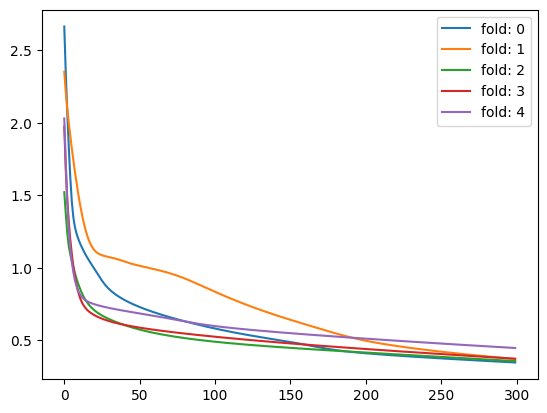

In [13]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

X = iris_df.iloc[:,0:4].copy()
y = iris_df.iloc[:, 4:5].copy()

accuracy_list = []
f1_list = []
val_list = []
pred_list = []
loss_list = []

# k-fold 교차 검증 수행
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # 모델 학습 및 평가
    model = MLP(hidden_size=10, learning_rate=0.08, epochs=300)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy_list.append(accuracy_score(y_val, y_pred))
    f1_list.append(f1_score(y_val, y_pred, average='weighted'))
    val_list.append(y_val)
    pred_list.append(y_pred)
    loss_list.append(model.retrunLossList())
    
print(f"accuracy: {accuracy_list}")
print(f"F1 weighted: {f1_list}")

for i in range(len(val_list)):
    print(f"Fold : {i}")
    printMultilabelConfusionMatrix(val_list[i], pred_list[i])
    print('='*20)
    
for i in range(len(loss_list)):
    x = [i for i in range(len(loss_list[i]))]
    y = loss_list[i]
    sns.lineplot(x=x, y=y, label=f'fold: {i}')
    plt.legend()
plt.show()

epoch 0, loss 2.1402626128441367
epoch 10, loss 0.7487018518699246
epoch 20, loss 0.6983646099286481
epoch 30, loss 0.6345648347087761
epoch 40, loss 0.5869815672463631
epoch 50, loss 0.5530338443095796
epoch 60, loss 0.5275804773130338
epoch 70, loss 0.5069185634235832
epoch 80, loss 0.4887582926136917
epoch 90, loss 0.4714489545712646
epoch 100, loss 0.4535748114943325
epoch 110, loss 0.43060290998679934
epoch 120, loss 0.4063399757113972
epoch 130, loss 0.3734204394495137
epoch 140, loss 0.34275121215948473
epoch 150, loss 0.3416649796513873
epoch 160, loss 0.3340191541683614
epoch 170, loss 0.32273661105461376
epoch 180, loss 0.31086007735827836
epoch 190, loss 0.29936522797871495
epoch 200, loss 0.28855777160283497
epoch 210, loss 0.2785139402192757
epoch 220, loss 0.2692192911918831
epoch 230, loss 0.2606229355692688
epoch 240, loss 0.2526626627520096
epoch 250, loss 0.24527694731573324
epoch 260, loss 0.2384100623277666
epoch 270, loss 0.23201351337859566
epoch 280, loss 0.22604

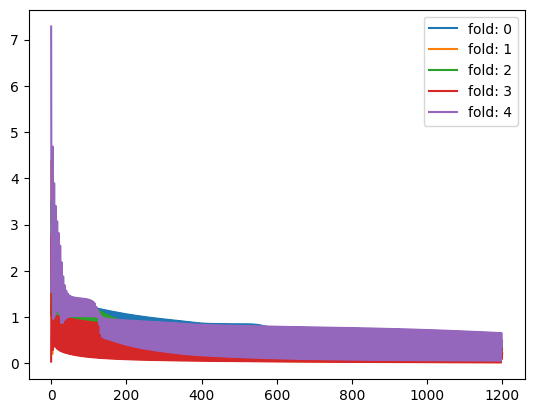

In [14]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

X = iris_df.iloc[:,0:4].copy()
y = iris_df.iloc[:, 4:5].copy()

accuracy_list = []
f1_list = []
val_list = []
pred_list = []
loss_list = []

# k-fold 교차 검증 수행
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # 모델 학습 및 평가
    model = MLP_MINIBATCH(hidden_size=10, learning_rate=0.08, epochs=300, batch_size=32)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy_list.append(accuracy_score(y_val,y_pred))
    f1_list.append(f1_score(y_val, y_pred, average='weighted'))
    val_list.append(y_val)
    pred_list.append(y_pred)
    loss_list.append(model.retrunLossList())    
    
print(f"accuracy: {accuracy_list}")
print(f"F1 weighted: {f1_list}")

for i in range(len(val_list)):
    print(f"Fold : {i}")
    printMultilabelConfusionMatrix(val_list[i], pred_list[i])
    print('='*20)
    
for i in range(len(loss_list)):
    x = [i for i in range(len(loss_list[i]))]
    y = loss_list[i]
    sns.lineplot(x=x, y=y, label=f'fold: {i}')
    plt.legend()
plt.show()

epoch 0, loss 2.3331207537697347
epoch 10, loss 1.2905724378430414
epoch 20, loss 0.9821156367514685
epoch 30, loss 0.8085128957626727
epoch 40, loss 0.694115099705454
epoch 50, loss 0.614493562551783
epoch 60, loss 0.5565671467790467
epoch 70, loss 0.512720326440026
epoch 80, loss 0.47835835080029376
epoch 90, loss 0.45061639120731045
epoch 100, loss 0.427648801491754
epoch 110, loss 0.4082278931154973
epoch 120, loss 0.39151183697536285
epoch 130, loss 0.3769068682987196
epoch 140, loss 0.3639832458077932
epoch 150, loss 0.3524225997186646
epoch 160, loss 0.3419840745047746
epoch 170, loss 0.33248201079969386
epoch 180, loss 0.3237708861564806
epoch 190, loss 0.3157349293682333
epoch 200, loss 0.3082808106862641
epoch 210, loss 0.3013323987695645
epoch 220, loss 0.29482693355747214
epoch 230, loss 0.2887121870513788
epoch 240, loss 0.2829443252599938
epoch 250, loss 0.2774862758233279
epoch 260, loss 0.27230646583359025
epoch 270, loss 0.26737783448553665
epoch 280, loss 0.2626770524

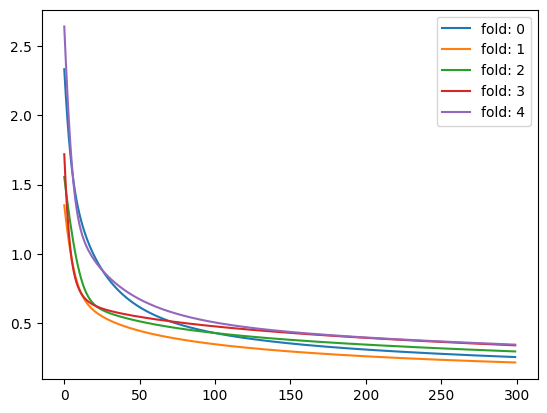

In [15]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

X = iris_df.iloc[:,0:4].copy()
y = iris_df.iloc[:, 4:5].copy()

accuracy_list = []
f1_list = []
val_list = []
pred_list = []
loss_list = []

# k-fold 교차 검증 수행
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # 표준화
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    
    # 모델 학습 및 평가
    model = MLP(hidden_size=10, learning_rate=0.08, epochs=300)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy_list.append(accuracy_score(y_val,y_pred))
    f1_list.append(f1_score(y_val, y_pred, average='weighted'))
    val_list.append(y_val)
    pred_list.append(y_pred)
    loss_list.append(model.retrunLossList())
    
print(f"accuracy: {accuracy_list}")
print(f"F1 weighted: {f1_list}")

for i in range(len(val_list)):
    print(f"Fold : {i}")
    printMultilabelConfusionMatrix(val_list[i], pred_list[i])
    print('='*20)
    
for i in range(len(loss_list)):
    x = [i for i in range(len(loss_list[i]))]
    y = loss_list[i]
    sns.lineplot(x=x, y=y, label=f'fold: {i}')
    plt.legend()
plt.show()

epoch 0, loss 1.191711353506095
epoch 10, loss 0.49018189546886837
epoch 20, loss 0.3705794701942256
epoch 30, loss 0.312062786065761
epoch 40, loss 0.2796377145454661
epoch 50, loss 0.2585853629733202
epoch 60, loss 0.2433212399935577
epoch 70, loss 0.23137499698836228
epoch 80, loss 0.221500441169725
epoch 90, loss 0.2130072484575638
epoch 100, loss 0.20548795284944402
epoch 110, loss 0.19869165257515053
epoch 120, loss 0.19245933053953493
epoch 130, loss 0.18668796425142217
epoch 140, loss 0.1813093702154258
epoch 150, loss 0.176277189343241
epoch 160, loss 0.17155866540110298
epoch 170, loss 0.1671293935452328
epoch 180, loss 0.1629699800309218
epoch 190, loss 0.15906395919517136
epoch 200, loss 0.15539654180149381
epoch 210, loss 0.15195390664884667
epoch 220, loss 0.14872283720167936
epoch 230, loss 0.14569056730784477
epoch 240, loss 0.1428447447418555
epoch 250, loss 0.14017345346682142
epoch 260, loss 0.137665258246763
epoch 270, loss 0.13530925081051873
epoch 280, loss 0.1330

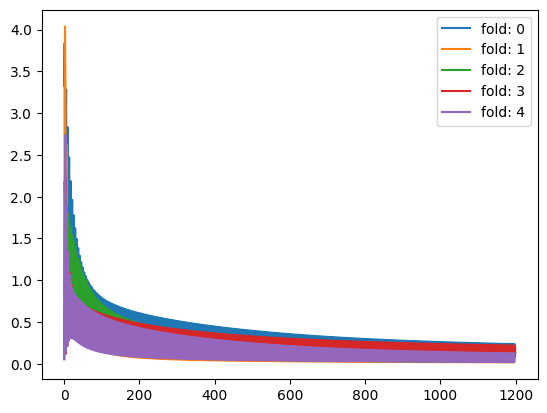

In [16]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

X = iris_df.iloc[:,0:4].copy()
y = iris_df.iloc[:, 4:5].copy()

accuracy_list = []
f1_list = []
val_list = []
pred_list = []
loss_list = []

# k-fold 교차 검증 수행
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # 표준화
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    
    # 모델 학습 및 평가
    model = MLP_MINIBATCH(hidden_size=10, learning_rate=0.08, epochs=300, batch_size=32)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy_list.append(accuracy_score(y_val,y_pred))
    f1_list.append(f1_score(y_val, y_pred, average='weighted'))
    val_list.append(y_val)
    pred_list.append(y_pred)
    loss_list.append(model.retrunLossList())
    
print(f"accuracy: {accuracy_list}")
print(f"F1 weighted: {f1_list}")

for i in range(len(val_list)):
    print(f"Fold : {i}")
    printMultilabelConfusionMatrix(val_list[i], pred_list[i])
    print('='*20)

for i in range(len(loss_list)):
    x = [i for i in range(len(loss_list[i]))]
    y = loss_list[i]
    sns.lineplot(x=x, y=y, label=f'fold: {i}')
    plt.legend()
plt.show()

#### scikit learn version

In [17]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

X = iris_df.iloc[:,0:4].copy()
y = iris_df.iloc[:, 4:5].copy()

accuracy_list = []
f1_list = []
val_list = []
pred_list = []

# k-fold 교차 검증 수행
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # 모델 학습 및 평가
    model = MLPClassifier(hidden_layer_sizes=(10,), activation='logistic', max_iter=1800, random_state=0).fit(X_train, np.array(y_train).reshape(-1, ))
    y_pred = model.predict(X_val)
    accuracy_list.append(accuracy_score(y_val, y_pred))
    f1_list.append(f1_score(y_val, y_pred, average='weighted'))
    val_list.append(y_val)
    pred_list.append(y_pred)
    
print(f"accuracy: {accuracy_list}")
print(f"F1 weighted: {f1_list}")

for i in range(len(val_list)):
    print(f"Fold : {i}")
    printMultilabelConfusionMatrix(val_list[i], pred_list[i])
    print('='*20)

accuracy: [1.0, 0.9333333333333333, 1.0, 1.0, 0.9333333333333333]
F1 weighted: [1.0, 0.9333333333333333, 1.0, 1.0, 0.9333333333333333]
Fold : 0
라벨 0의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     19      0
실제값 T      0     11
라벨 1의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     17      0
실제값 T      0     13
라벨 2의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     24      0
실제값 T      0      6
Fold : 1
라벨 0의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     25      0
실제값 T      0      5
라벨 1의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     19      1
실제값 T      1      9
라벨 2의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     14      1
실제값 T      1     14
Fold : 2
라벨 0의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     20      0
실제값 T      0     10
라벨 1의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     20      0
실제값 T      0     10
라벨 2의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     20      0
실제값 T      0     10
Fold : 3
라벨 0의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     16      0
실제값 T      0     14
라벨 1의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     24      0
실제값 T      0      6
라벨 2의 혼동행렬 :
       예측값 N 

In [18]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

X = iris_df.iloc[:,0:4].copy()
y = iris_df.iloc[:, 4:5].copy()

accuracy_list = []
f1_list = []
val_list = []
pred_list = []

# k-fold 교차 검증 수행
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # 표준화
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    
    # 모델 학습 및 평가
    model = MLPClassifier(hidden_layer_sizes=(10,), activation='logistic', max_iter=1800, random_state=0).fit(X_train, np.array(y_train).reshape(-1, ))
    y_pred = model.predict(X_val)
    accuracy_list.append(accuracy_score(y_val,y_pred))
    f1_list.append(f1_score(y_val, y_pred, average='weighted'))
    val_list.append(y_val)
    pred_list.append(y_pred)
    
print(f"accuracy: {accuracy_list}")
print(f"F1 weighted: {f1_list}")

for i in range(len(val_list)):
    print(f"Fold : {i}")
    printMultilabelConfusionMatrix(val_list[i], pred_list[i])
    print('='*20)

accuracy: [1.0, 0.9, 0.9666666666666667, 1.0, 0.9]
F1 weighted: [1.0, 0.9009661835748793, 0.9665831244778613, 1.0, 0.899248120300752]
Fold : 0
라벨 0의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     19      0
실제값 T      0     11
라벨 1의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     17      0
실제값 T      0     13
라벨 2의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     24      0
실제값 T      0      6
Fold : 1
라벨 0의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     25      0
실제값 T      0      5
라벨 1의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     17      3
실제값 T      0     10
라벨 2의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     15      0
실제값 T      3     12
Fold : 2
라벨 0의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     20      0
실제값 T      0     10
라벨 1의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     20      0
실제값 T      1      9
라벨 2의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     19      1
실제값 T      0     10
Fold : 3
라벨 0의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     16      0
실제값 T      0     14
라벨 1의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     24      0
실제값 T      0      6
라벨 2의 혼동행렬 :
       예측값 N  

In [19]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

X = iris_df.iloc[:,0:4].copy()
y = iris_df.iloc[:, 4:5].copy()

accuracy_list = []
f1_list = []
val_list = []
pred_list = []

# k-fold 교차 검증 수행
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # 모델 학습 및 평가
    model = MLPClassifier(hidden_layer_sizes=(10,), activation='logistic', max_iter=300, random_state=0).fit(X_train, np.array(y_train).reshape(-1, ))
    y_pred = model.predict(X_val)
    accuracy_list.append(accuracy_score(y_val, y_pred))
    f1_list.append(f1_score(y_val, y_pred, average='weighted'))
    val_list.append(y_val)
    pred_list.append(y_pred)
    
print(f"accuracy: {accuracy_list}")
print(f"F1 weighted: {f1_list}")

for i in range(len(val_list)):
    print(f"Fold : {i}")
    printMultilabelConfusionMatrix(val_list[i], pred_list[i])
    print('='*20)

/opt/anaconda3/envs/study/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/study/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/study/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/study/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/study/li

accuracy: [0.5666666666666667, 0.5, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666]
F1 weighted: [0.4626666666666666, 0.35714285714285715, 0.6632996632996632, 0.5757575757575758, 0.6458333333333334]
Fold : 0
라벨 0의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     19      0
실제값 T      0     11
라벨 1의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     17      0
실제값 T     13      0
라벨 2의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     11     13
실제값 T      0      6
Fold : 1
라벨 0의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     25      0
실제값 T      0      5
라벨 1의 혼동행렬 :
       예측값 N  예측값 T
실제값 N      5     15
실제값 T      0     10
라벨 2의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     15      0
실제값 T     15      0
Fold : 2
라벨 0의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     20      0
실제값 T      0     10
라벨 1의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     14      6
실제값 T      4      6
라벨 2의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     16      4
실제값 T      6      4
Fold : 3
라벨 0의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     16      0
실제값 T      0     14
라벨 1의 혼동행렬 :
       예측값

In [20]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

X = iris_df.iloc[:,0:4].copy()
y = iris_df.iloc[:, 4:5].copy()

accuracy_list = []
f1_list = []
val_list = []
pred_list = []

# k-fold 교차 검증 수행
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # 표준화
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    
    # 모델 학습 및 평가
    model = MLPClassifier(hidden_layer_sizes=(10,), activation='logistic', max_iter=300, random_state=0).fit(X_train, np.array(y_train).reshape(-1, ))
    y_pred = model.predict(X_val)
    accuracy_list.append(accuracy_score(y_val,y_pred))
    f1_list.append(f1_score(y_val, y_pred, average='weighted'))
    val_list.append(y_val)
    pred_list.append(y_pred)
    
print(f"accuracy: {accuracy_list}")
print(f"F1 weighted: {f1_list}")

for i in range(len(val_list)):
    print(f"Fold : {i}")
    printMultilabelConfusionMatrix(val_list[i], pred_list[i])
    print('='*20)

accuracy: [0.6666666666666666, 0.7, 0.9, 0.9, 0.8666666666666667]
F1 weighted: [0.6382575757575758, 0.7, 0.8976982097186702, 0.8978354978354979, 0.8639730639730641]
Fold : 0
라벨 0의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     19      0
실제값 T      0     11
라벨 1의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     17      0
실제값 T     10      3
라벨 2의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     14     10
실제값 T      0      6
Fold : 1
라벨 0의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     25      0
실제값 T      0      5
라벨 1의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     13      7
실제값 T      2      8
라벨 2의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     13      2
실제값 T      7      8
Fold : 2
라벨 0의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     20      0
실제값 T      0     10
라벨 1의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     20      0
실제값 T      3      7
라벨 2의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     17      3
실제값 T      0     10
Fold : 3
라벨 0의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     16      0
실제값 T      0     14
라벨 1의 혼동행렬 :
       예측값 N  예측값 T
실제값 N     23      1
실제값 T      2    

/opt/anaconda3/envs/study/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/study/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/study/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/study/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/study/li

### MNIST data

In [21]:
from sklearn.datasets import fetch_openml

In [22]:
mnist = fetch_openml('mnist_784', parser='pandas', as_frame=False)

In [23]:
print(mnist)

{'data': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 'target': array(['5', '0', '4', ..., '4', '5', '6'], dtype=object), 'frame': None, 'categories': {'class': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']}, 'feature_names': ['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9', 'pixel10', 'pixel11', 'pixel12', 'pixel13', 'pixel14', 'pixel15', 'pixel16', 'pixel17', 'pixel18', 'pixel19', 'pixel20', 'pixel21', 'pixel22', 'pixel23', 'pixel24', 'pixel25', 'pixel26', 'pixel27', 'pixel28', 'pixel29', 'pixel30', 'pixel31', 'pixel32', 'pixel33', 'pixel34', 'pixel35', 'pixel36', 'pixel37', 'pixel38', 'pixel39', 'pixel40', 'pixel41', 'pixel42', 'pixel43', 'pixel44', 'pixel45', 'pixel46', 'pixel47', 'pixel48', 'pixel49', 'pixel50', 'pixel51', 'pixel52', 'pixel53', 'pixel54', 'pixel55', 'pixel56', 

In [24]:
mnist_df = pd.DataFrame(data=mnist['data'], columns=mnist['feature_names'])
mnist_df['target'] = mnist['target']

In [25]:
mnist_df.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [26]:
mnist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 785 entries, pixel1 to target
dtypes: int64(784), object(1)
memory usage: 419.2+ MB


In [27]:
mnist_df = mnist_df.astype({'target':'int64'})

In [28]:
mnist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 785 entries, pixel1 to target
dtypes: int64(785)
memory usage: 419.2 MB


In [29]:
digit = mnist_df.iloc[:1,:-1].to_numpy()
digit_image = digit.reshape(28, 28)

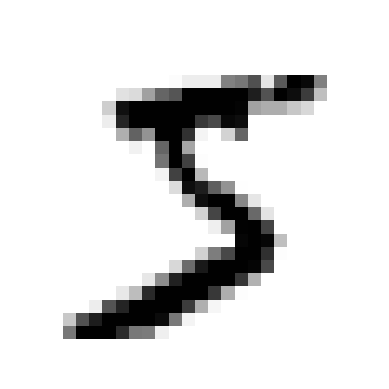

In [30]:
plt.imshow(digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [31]:
# 데이터 정규화
mnist_df_scaled = pd.DataFrame(data=mnist_df.iloc[:,:-1].copy()/255, columns=mnist_df.iloc[:,:-1].columns)
mnist_df_scaled['target'] = mnist_df['target']

In [32]:
digit = mnist_df_scaled.iloc[:1,:-1].to_numpy()
digit_image = digit.reshape(28, 28)

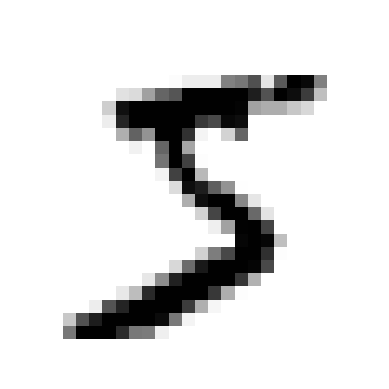

In [33]:
plt.imshow(digit_image, cmap='binary')
plt.axis('off')
plt.show()

epoch 0, loss 6.571232287599395
epoch 10, loss 5.8083301422528715
epoch 20, loss 5.34971800918568
epoch 30, loss 4.966635706742043
epoch 40, loss 4.656741669030107
epoch 0, loss 6.688795391820425
epoch 10, loss 5.9493939699855005
epoch 20, loss 5.547529698935775
epoch 30, loss 5.2253185532212765
epoch 40, loss 4.92962815728852
epoch 0, loss 6.937197897851486
epoch 10, loss 5.851247678499334
epoch 20, loss 5.359336329235387
epoch 30, loss 5.0052952305672616
epoch 40, loss 4.720862291673007
epoch 0, loss 7.289141209582713
epoch 10, loss 6.399193756104146
epoch 20, loss 5.44536055218436
epoch 30, loss 5.017112822571462
epoch 40, loss 4.735030338052974
epoch 0, loss 7.228293715827691
epoch 10, loss 5.440794579943055
epoch 20, loss 4.8990185970809
epoch 30, loss 4.550005450237273
epoch 40, loss 4.280027701138961
accuracy: [0.2322142857142857, 0.2092142857142857, 0.22107142857142856, 0.21614285714285714, 0.273]
F1 weighted: [0.23180647584952677, 0.20770019242949891, 0.22037136413272643, 0.21

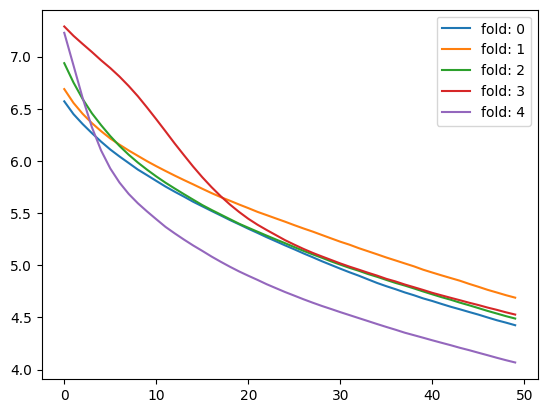

In [118]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

X = mnist_df.iloc[:,:-1].copy()
y = mnist_df.iloc[:,-1:].copy()

accuracy_list = []
f1_list = []
val_list = []
pred_list = []
loss_list = []

# k-fold 교차 검증 수행
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # 모델 학습 및 평가
    model = MLP(hidden_size=128, learning_rate=0.08, epochs=50)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy_list.append(accuracy_score(y_val,y_pred))
    f1_list.append(f1_score(y_val, y_pred, average='weighted'))
    val_list.append(y_val)
    pred_list.append(y_pred)
    loss_list.append(model.retrunLossList())
    
print(f"accuracy: {accuracy_list}")
print(f"F1 weighted: {f1_list}")

for i in range(len(val_list)):
    print(f"Fold : {i}")
    printMultilabelConfusionMatrix(val_list[i], pred_list[i])
    print('='*20)

for i in range(len(loss_list)):
    x = [i for i in range(len(loss_list[i]))]
    y = loss_list[i]
    sns.lineplot(x=x, y=y, label=f'fold: {i}')
    plt.legend()
plt.show()

epoch 0, loss 7.140812801287712
epoch 10, loss 6.114678488082761
epoch 20, loss 5.528917459367374
epoch 30, loss 4.878520349361518
epoch 40, loss 4.405434020472428
epoch 0, loss 7.685874127175795
epoch 10, loss 5.56835833680444
epoch 20, loss 4.9507890580919085
epoch 30, loss 4.538157829039319
epoch 40, loss 4.182644309620799
epoch 0, loss 7.558372204832396
epoch 10, loss 5.904164966853366
epoch 20, loss 5.044393853761837
epoch 30, loss 4.610605141130505
epoch 40, loss 4.257597188791096
epoch 0, loss 6.675670363117802
epoch 10, loss 5.946135080623376
epoch 20, loss 5.204792528473194
epoch 30, loss 4.657170257660999
epoch 40, loss 4.282405976163344
epoch 0, loss 6.359028598509122
epoch 10, loss 5.457682830968011
epoch 20, loss 4.7017640340214815
epoch 30, loss 4.2600419564251775
epoch 40, loss 3.902196410183564
accuracy: [0.22807142857142856, 0.22214285714285714, 0.2287857142857143, 0.24414285714285713, 0.24814285714285714]
F1 weighted: [0.22773881944327948, 0.22141156958037772, 0.22538

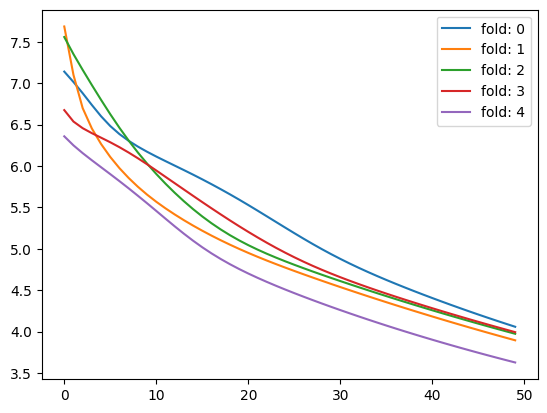

In [36]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

X = mnist_df_scaled.iloc[:,:-1].copy()
y = mnist_df_scaled.iloc[:,-1:].copy()

accuracy_list = []
f1_list = []
val_list = []
pred_list = []
loss_list = []

# k-fold 교차 검증 수행
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # 모델 학습 및 평가
    model = MLP(hidden_size=128, learning_rate=0.08, epochs=50)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy_list.append(accuracy_score(y_val,y_pred))
    f1_list.append(f1_score(y_val, y_pred, average='weighted'))
    val_list.append(y_val)
    pred_list.append(y_pred)
    loss_list.append(model.retrunLossList())
    
print(f"accuracy: {accuracy_list}")
print(f"F1 weighted: {f1_list}")

for i in range(len(val_list)):
    print(f"Fold : {i}")
    printMultilabelConfusionMatrix(val_list[i], pred_list[i])
    print('='*20)

for i in range(len(loss_list)):
    x = [i for i in range(len(loss_list[i]))]
    y = loss_list[i]
    sns.lineplot(x=x, y=y, label=f'fold: {i}')
    plt.legend()
plt.show()

epoch 0, loss 2.6136789933105344
epoch 10, loss 0.9896306523217087
epoch 20, loss 0.7435240968291885
epoch 30, loss 0.7228297014774157
epoch 40, loss 0.6902881658121247
epoch 0, loss 2.4599815578859032
epoch 10, loss 0.7728955909138097
epoch 20, loss 0.7116798900619709
epoch 30, loss 0.5757754910364221
epoch 40, loss 0.5069348273183578
epoch 0, loss 2.500095210175102
epoch 10, loss 0.8834050797786713
epoch 20, loss 0.6168812346649544
epoch 30, loss 0.5578860395609104
epoch 40, loss 0.4653115013076324
epoch 0, loss 2.283290653125958
epoch 10, loss 0.9808344139315122
epoch 20, loss 0.7786076866224496
epoch 30, loss 0.692457266210087
epoch 40, loss 0.6637004681387814
epoch 0, loss 2.373654960837563
epoch 10, loss 0.8879594172036914
epoch 20, loss 0.7916850155220283
epoch 30, loss 0.6379682310203278
epoch 40, loss 0.5849399448297098
accuracy: [0.8864285714285715, 0.8892857142857142, 0.8936428571428572, 0.8835714285714286, 0.89]
F1 weighted: [0.8862846113224317, 0.8889600491089018, 0.893657

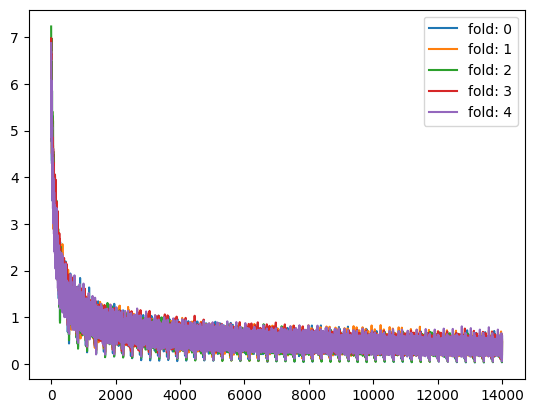

In [37]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

X = mnist_df.iloc[:,:-1].copy()
y = mnist_df.iloc[:,-1:].copy()

accuracy_list = []
f1_list = []
val_list = []
pred_list = []
loss_list = []

# k-fold 교차 검증 수행
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # 모델 학습 및 평가
    model = MLP_MINIBATCH(hidden_size=128, learning_rate=0.08, epochs=50, batch_size=200)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy_list.append(accuracy_score(y_val,y_pred))
    f1_list.append(f1_score(y_val, y_pred, average='weighted'))
    val_list.append(y_val)
    pred_list.append(y_pred)
    loss_list.append(model.retrunLossList())
    
print(f"accuracy: {accuracy_list}")
print(f"F1 weighted: {f1_list}")

for i in range(len(val_list)):
    print(f"Fold : {i}")
    printMultilabelConfusionMatrix(val_list[i], pred_list[i])
    print('='*20)

for i in range(len(loss_list)):
    x = [i for i in range(len(loss_list[i]))]
    y = loss_list[i]
    sns.lineplot(x=x, y=y, label=f'fold: {i}')
    plt.legend()
plt.show()

epoch 0, loss 1.9685254544538169
epoch 10, loss 0.796551726772872
epoch 20, loss 0.638675523804684
epoch 30, loss 0.5571465178827056
epoch 40, loss 0.49761472141766816
epoch 0, loss 1.8003284168163571
epoch 10, loss 0.775750229755533
epoch 20, loss 0.6176027782262191
epoch 30, loss 0.5170710692917484
epoch 40, loss 0.44678087551824247
epoch 0, loss 1.762279953748679
epoch 10, loss 0.6471088875285628
epoch 20, loss 0.4886725051899161
epoch 30, loss 0.41520471423649413
epoch 40, loss 0.3708188211992085
epoch 0, loss 1.62989584863733
epoch 10, loss 0.6217544653777491
epoch 20, loss 0.48554692462172006
epoch 30, loss 0.427979385581185
epoch 40, loss 0.39195012861614276
epoch 0, loss 1.8852964212399963
epoch 10, loss 0.8221775096701092
epoch 20, loss 0.6400118128843352
epoch 30, loss 0.548357802259011
epoch 40, loss 0.48493154306232694
accuracy: [0.9082142857142858, 0.9098571428571428, 0.9112857142857143, 0.9109285714285714, 0.9083571428571429]
F1 weighted: [0.9082938913866283, 0.9097141883

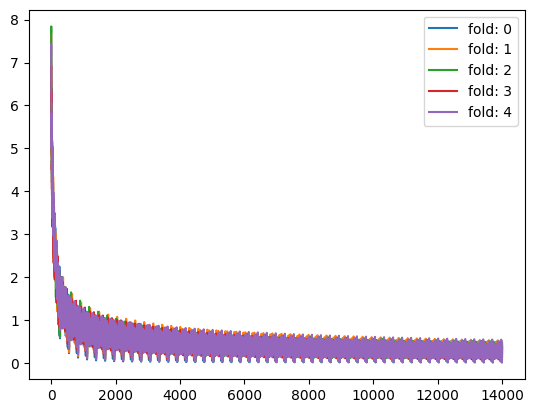

In [38]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

X = mnist_df_scaled.iloc[:,:-1].copy()
y = mnist_df_scaled.iloc[:,-1:].copy()

accuracy_list = []
f1_list = []
val_list = []
pred_list = []
loss_list = []

# k-fold 교차 검증 수행
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # 모델 학습 및 평가
    model = MLP_MINIBATCH(hidden_size=128, learning_rate=0.08, epochs=50, batch_size=200)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy_list.append(accuracy_score(y_val,y_pred))
    f1_list.append(f1_score(y_val, y_pred, average='weighted'))
    val_list.append(y_val)
    pred_list.append(y_pred)
    loss_list.append(model.retrunLossList())
    
print(f"accuracy: {accuracy_list}")
print(f"F1 weighted: {f1_list}")

for i in range(len(val_list)):
    print(f"Fold : {i}")
    printMultilabelConfusionMatrix(val_list[i], pred_list[i])
    print('='*20)

for i in range(len(loss_list)):
    x = [i for i in range(len(loss_list[i]))]
    y = loss_list[i]
    sns.lineplot(x=x, y=y, label=f'fold: {i}')
    plt.legend()
plt.show()

#### scikit learn version

In [34]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

X = mnist_df.iloc[:,:-1].copy()
y = mnist_df.iloc[:,-1:].copy()

accuracy_list = []
f1_list = []
val_list = []
pred_list = []

# k-fold 교차 검증 수행
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # 모델 학습 및 평가
    mlp = MLPClassifier(hidden_layer_sizes=(128,), activation='logistic', max_iter=50, random_state=0).fit(X_train, np.array(y_train).reshape(-1, ))
    y_pred = mlp.predict(X_val)
    accuracy_list.append(accuracy_score(y_val,y_pred))
    f1_list.append(f1_score(y_val, y_pred, average='weighted'))
    val_list.append(y_val)
    pred_list.append(y_pred)
    
print(f"accuracy: {accuracy_list}")
print(f"F1 weighted: {f1_list}")

for i in range(len(val_list)):
    print(f"Fold : {i}")
    printMultilabelConfusionMatrix(val_list[i], pred_list[i])
    print('='*20)

/opt/anaconda3/envs/study/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/study/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/study/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/study/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/study/lib/py

accuracy: [0.9473571428571429, 0.9542857142857143, 0.9537857142857142, 0.9495714285714286, 0.9547142857142857]
F1 weighted: [0.9473509175334371, 0.9542426558569282, 0.9537453415253074, 0.9495346897552299, 0.9547030502360467]
Fold : 0
라벨 0의 혼동행렬 :
       예측값 N  예측값 T
실제값 N  12561     52
실제값 T     30   1357
라벨 1의 혼동행렬 :
       예측값 N  예측값 T
실제값 N  12385     35
실제값 T     37   1543
라벨 2의 혼동행렬 :
       예측값 N  예측값 T
실제값 N  12491     66
실제값 T     83   1360
라벨 3의 혼동행렬 :
       예측값 N  예측값 T
실제값 N  12442    123
실제값 T     77   1358
라벨 4의 혼동행렬 :
       예측값 N  예측값 T
실제값 N  12577     73
실제값 T     87   1263
라벨 5의 혼동행렬 :
       예측값 N  예측값 T
실제값 N  12728     41
실제값 T    122   1109
라벨 6의 혼동행렬 :
       예측값 N  예측값 T
실제값 N  12562     51
실제값 T     54   1333
라벨 7의 혼동행렬 :
       예측값 N  예측값 T
실제값 N  12472     70
실제값 T     72   1386
라벨 8의 혼동행렬 :
       예측값 N  예측값 T
실제값 N  12518    114
실제값 T     73   1295
라벨 9의 혼동행렬 :
       예측값 N  예측값 T
실제값 N  12527    112
실제값 T    102   1259
Fold : 1
라벨 0의 혼동행렬 :
       예측값 N  

In [35]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

X = mnist_df_scaled.iloc[:,:-1].copy()
y = mnist_df_scaled.iloc[:,-1:].copy()

accuracy_list = []
f1_list = []
val_list = []
pred_list = []

# k-fold 교차 검증 수행
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # 모델 학습 및 평가
    mlp = MLPClassifier(hidden_layer_sizes=(128,), activation='logistic', max_iter=50, random_state=0).fit(X_train, np.array(y_train).reshape(-1, ))
    y_pred = mlp.predict(X_val)
    accuracy_list.append(accuracy_score(y_val,y_pred))
    f1_list.append(f1_score(y_val, y_pred, average='weighted'))
    val_list.append(y_val)
    pred_list.append(y_pred)
    
print(f"accuracy: {accuracy_list}")
print(f"F1 weighted: {f1_list}")

for i in range(len(val_list)):
    print(f"Fold : {i}")
    printMultilabelConfusionMatrix(val_list[i], pred_list[i])
    print('='*20)

/opt/anaconda3/envs/study/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/study/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/study/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/study/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


accuracy: [0.975, 0.9763571428571428, 0.9757857142857143, 0.9789285714285715, 0.9782857142857143]
F1 weighted: [0.9749964968468701, 0.9763502459885437, 0.9757723215690811, 0.9789138105037976, 0.9782874686668079]
Fold : 0
라벨 0의 혼동행렬 :
       예측값 N  예측값 T
실제값 N  12595     18
실제값 T     16   1371
라벨 1의 혼동행렬 :
       예측값 N  예측값 T
실제값 N  12397     23
실제값 T     23   1557
라벨 2의 혼동행렬 :
       예측값 N  예측값 T
실제값 N  12514     43
실제값 T     35   1408
라벨 3의 혼동행렬 :
       예측값 N  예측값 T
실제값 N  12516     49
실제값 T     51   1384
라벨 4의 혼동행렬 :
       예측값 N  예측값 T
실제값 N  12616     34
실제값 T     29   1321
라벨 5의 혼동행렬 :
       예측값 N  예측값 T
실제값 N  12741     28
실제값 T     49   1182
라벨 6의 혼동행렬 :
       예측값 N  예측값 T
실제값 N  12585     28
실제값 T     24   1363
라벨 7의 혼동행렬 :
       예측값 N  예측값 T
실제값 N  12513     29
실제값 T     35   1423
라벨 8의 혼동행렬 :
       예측값 N  예측값 T
실제값 N  12584     48
실제값 T     47   1321
라벨 9의 혼동행렬 :
       예측값 N  예측값 T
실제값 N  12589     50
실제값 T     41   1320
Fold : 1
라벨 0의 혼동행렬 :
       예측값 N  예측값 T
실제값 N  

/opt/anaconda3/envs/study/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
